Get data and import all needed libraries

In [ ]:
!pip3 install tqdm

In [ ]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sb
import seaborn as sns
import torch
import torch.nn.functional as F
from IPython.display import clear_output
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from torch import nn
from torch.autograd import Variable
from torch.nn import Parameter
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Run only in collab:
(in your google folder should be created folder Kaggle)
It is rather easier to download data from next link:
https://www.kaggle.com/gpiosenka/100-bird-species

and unzip it in root folder

In [ ]:
# download dataset
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

    !pip install kaggle
    !mkdir data
    !kaggle datasets download -d gpiosenka/100-bird-species
    !unzip 100-bird-species.zip -d data

    clear_output()

Getting all data

In [ ]:
DATA_PATH = f'{os.getcwd()}/data'
TRAIN_PATH = f'{DATA_PATH}/train'
TEST_PATH = f'{DATA_PATH}/test'
TYPE_PATH = "{}/{}"

NUM_ELEMENTS_TO_SHOW = 200

# Get train and test data with labels
def get_data_and_labels(n_first_classes = None):
    types = os.listdir(TRAIN_PATH)

    train, test = [], []
    
    n_class = 0
    for tp in tqdm(types[:n_first_classes]):
        if (n_class == n_first_classes):
            break
        
        train_type_path = TYPE_PATH.format(TRAIN_PATH,tp)
        for img in os.listdir(train_type_path):
            image = cv2.imread(TYPE_PATH.format(train_type_path,img), cv2.IMREAD_COLOR)
            train.append([tp,image])

        test_type_path = TYPE_PATH.format(TEST_PATH,tp)
        for img in os.listdir(test_type_path):
            image = cv2.imread(TYPE_PATH.format(test_type_path,img), cv2.IMREAD_COLOR)
            test.append([tp,image])
        n_class += 1
        
    train_labels = [i[0] for i in train]
    train_data = [i[1] for i in train]

    test_labels = [i[0] for i in test]
    test_data = [i[1] for i in test]
    print("Loading data done")
    
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = get_data_and_labels(n_first_classes = 100)

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]

Loading data done


Labels encoding

In [ ]:
types = list(set(train_labels))
encoder = {key: ind for ind, key in enumerate(types)}
decoder = {val: key for key, val in encoder.items()}
encoder

{'ALEXANDRINE PARAKEET': 64,
 'AMERICAN AVOCET': 83,
 'AMERICAN GOLDFINCH': 2,
 'AMERICAN KESTREL': 61,
 'AMERICAN REDSTART': 38,
 'ANHINGA': 58,
 'BALI STARLING': 60,
 'BALTIMORE ORIOLE': 79,
 'BAR-TAILED GODWIT': 9,
 'BARRED PUFFBIRD': 89,
 'BAY-BREASTED WARBLER': 47,
 'BIRD OF PARADISE': 69,
 'BLACK FRANCOLIN': 13,
 'BLACK THROATED WARBLER': 50,
 'BLACK-CAPPED CHICKADEE': 94,
 'BLACK-NECKED GREBE': 76,
 'BLACK-THROATED SPARROW': 70,
 'BLUE GROUSE': 17,
 'BLUE HERON': 21,
 'BOBOLINK': 62,
 'BROWN NOODY': 68,
 'CANARY': 96,
 'CAPE MAY WARBLER': 56,
 'CARMINE BEE-EATER': 67,
 'CASPIAN TERN': 65,
 'CASSOWARY': 19,
 'CHARA DE COLLAR': 3,
 'CINNAMON TEAL': 31,
 'COCKATOO': 39,
 'COMMON LOON': 34,
 'COUCHS KINGBIRD': 88,
 'CRESTED CARACARA': 86,
 'CROWNED PIGEON': 49,
 'D-ARNAUDS BARBET': 82,
 'DOWNY WOODPECKER': 80,
 'EASTERN MEADOWLARK': 12,
 'EASTERN ROSELLA': 63,
 'ELLIOTS  PHEASANT': 4,
 'EMU': 51,
 'EVENING GROSBEAK': 6,
 'FLAME TANAGER': 54,
 'FRIGATE': 52,
 'GILDED FLICKER': 78,
 '

Getting train and test data and labels

In [ ]:
train_labels, test_labels = np.array(train_labels), np.array(test_labels)
train_data, test_data = np.array(train_data), np.array(test_data)

Showing data length

In [ ]:
print(len(test_data), len(test_labels), len(train_data), len(train_labels))

500 500 13971 13971


Show train data

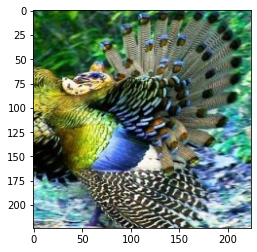

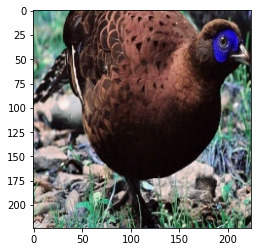

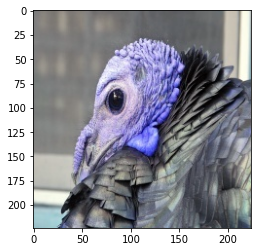

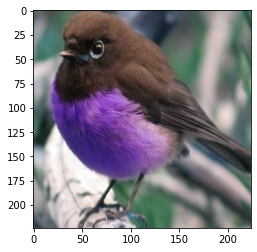

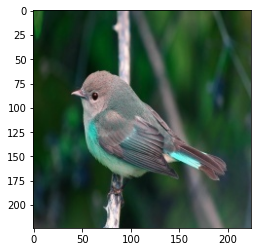

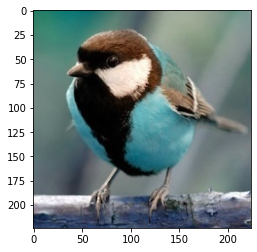

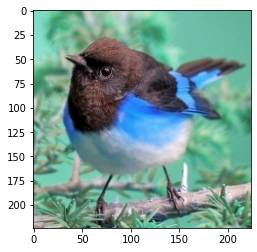

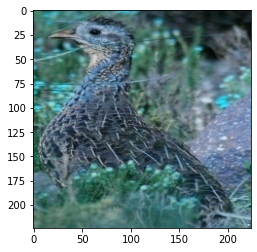

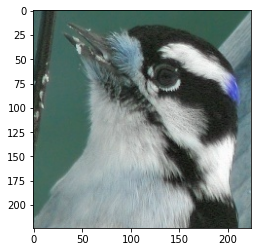

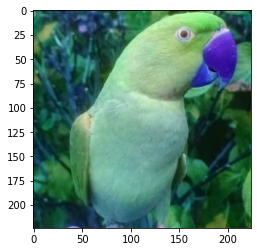

<Figure size 432x288 with 0 Axes>

In [ ]:
from random import choice
for i in range(10):
    plt.imshow(choice(train_data))
    plt.figure()

In [ ]:
def show_examples(imgs, labels):
    plt.figure(figsize=(20, 20))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        j = 100*i
        plt.title(labels[j])
        plt.imshow(imgs[j])
    plt.show()

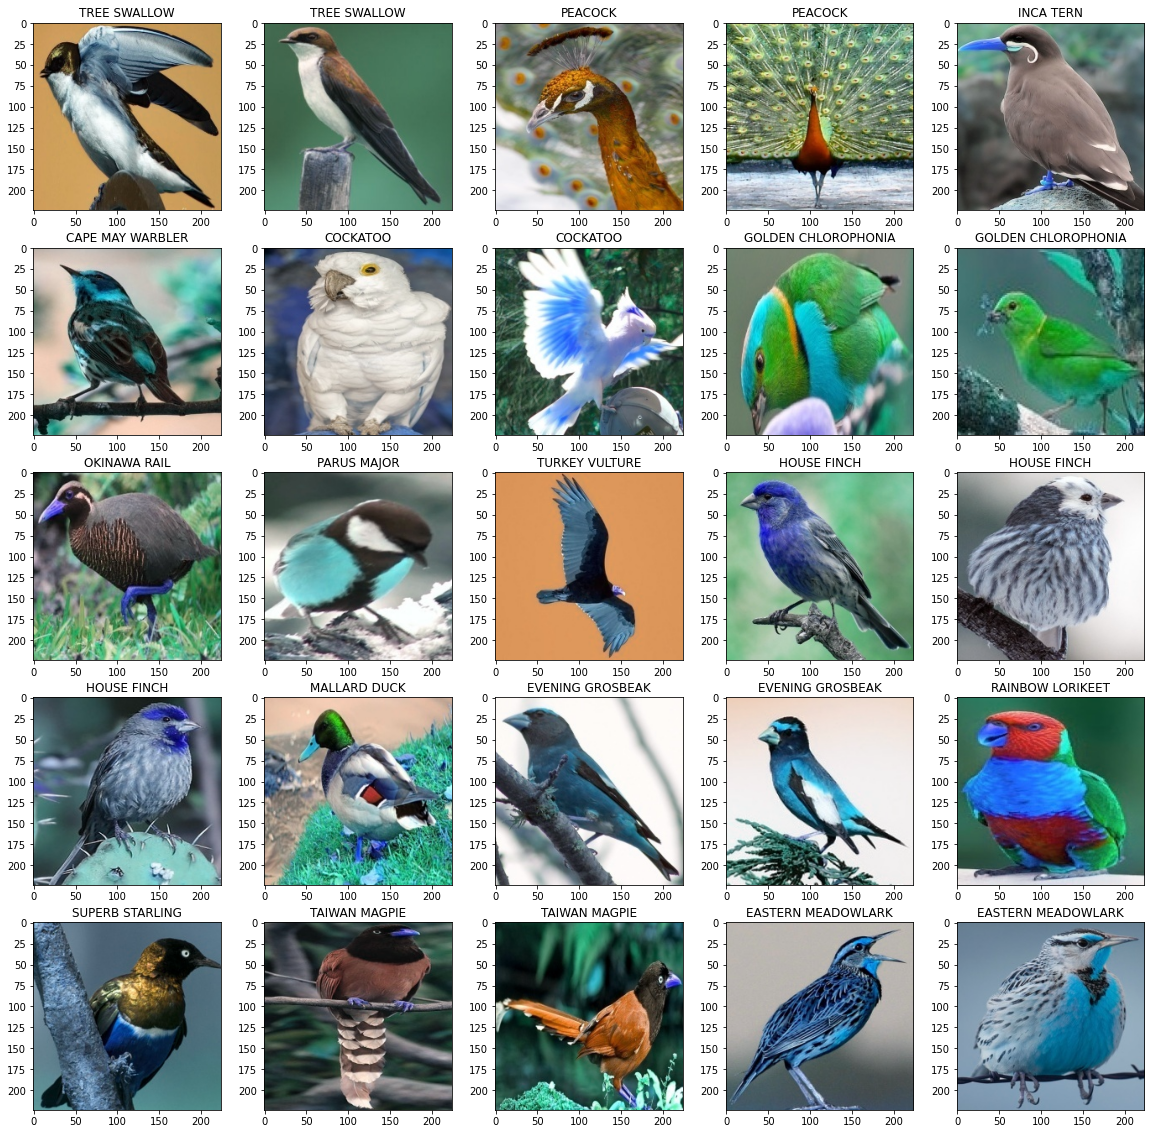

In [ ]:
show_examples(train_data, train_labels)

Get tSNE embeddings

In [ ]:
TSNE_TRAIN_SHAPE = (40, 40)
ENCODER_TRAIN_SHAPE = (144, 144)

In [ ]:
def train_embeddings(data):
    return TSNE(n_components=3).fit_transform(data)

def get_tsne_train_data(imgs, labels):
    resized = np.array([cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), TSNE_TRAIN_SHAPE) for im in imgs])
    X_Data, _, X_labels, _ = train_test_split(resized, labels, test_size=0.8, stratify=labels)
    return X_Data.flatten().reshape(X_Data.shape[0], TSNE_TRAIN_SHAPE[0] * TSNE_TRAIN_SHAPE[1] * 1), X_labels


In [ ]:
tsne_train_data, tsne_train_labels = get_tsne_train_data(train_data, train_labels)
print(len(tsne_train_data), len(tsne_train_labels))
tsne_embeddings = train_embeddings(tsne_train_data)

2794 2794


Show 2d image distribution

In [ ]:
def plot2d(tsne, labels):
    num = len(labels)
    palette = sb.color_palette("bright", np.unique(labels[:num]).shape[0])
    plot = sb.scatterplot(tsne[:, 0], tsne[:, 1], hue=labels[:num], legend='full', palette=palette).set_title(
        "Distribution")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
def plot3d(tsne, train_labels):
    num = len(train_labels)
    fig = px.scatter_3d(x=tsne[::, 0],
                        y=tsne[::, 1],
                        z=tsne[::, 2],
                        color=[str(label) for label in train_labels[:num]],
                        opacity=0.7)
    fig.show()


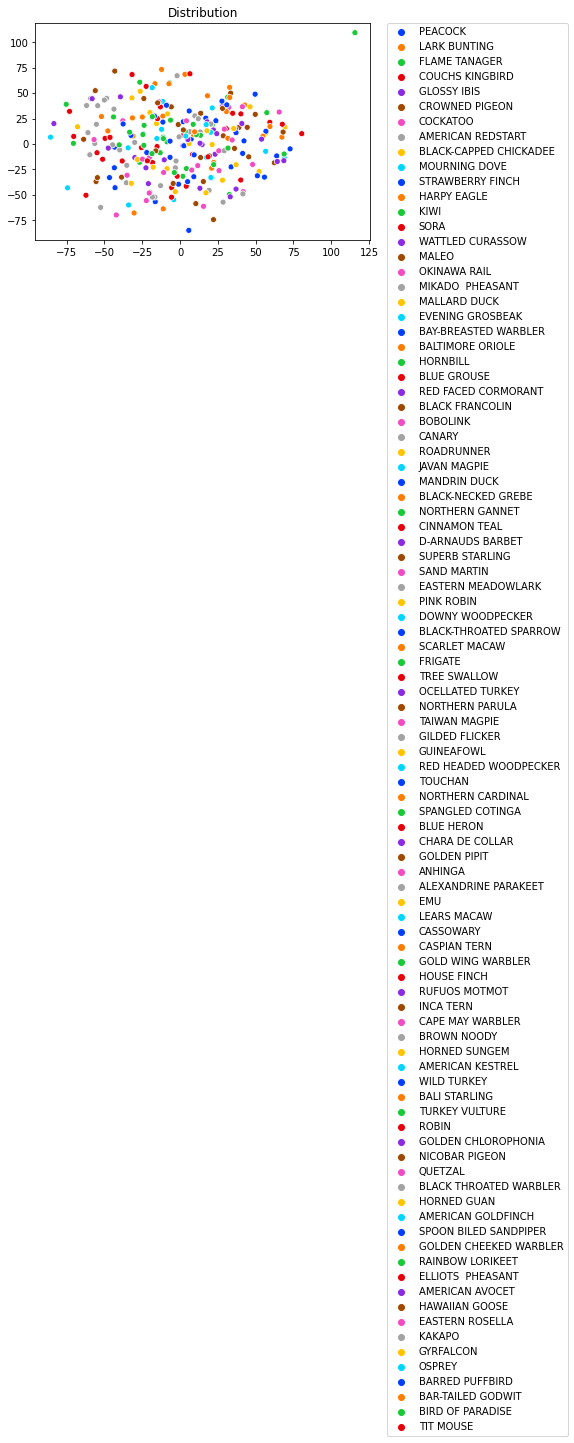

In [ ]:
plot2d(tsne_embeddings[::10], tsne_train_labels[::10])

Show 3d image distribution

In [ ]:
plot3d(tsne_embeddings[::2], tsne_train_labels[::2])

Autoencoder class

In [ ]:
dim = 1

class AutoEncoder(nn.Module):
  
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
                            nn.Conv2d(dim, 32, 3, padding=1), 
                            nn.ReLU(),
                            nn.BatchNorm2d(32),
                            nn.MaxPool2d(2), 

                            nn.Conv2d(32, 16, 3, padding=1),

                            nn.ReLU(),
                            nn.BatchNorm2d(16),
                            nn.MaxPool2d(2),  

                            nn.Conv2d(16, 8, 3, padding=1), 

                            nn.ReLU(),
                            nn.BatchNorm2d(8),
                            nn.MaxPool2d(2)  
                            )
        
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(8, 16, 3, 2, 1, 1),

                        nn.ReLU(),
                        nn.BatchNorm2d(16),

                        nn.ConvTranspose2d(16, 32, 3, 2, 1, 1),

                        nn.ReLU(),
                        nn.BatchNorm2d(32),

                        nn.ConvTranspose2d(32, dim, 3, 2, 1, 1),

                        nn.ReLU())

        self.model = nn.Sequential(self.encoder, self.decoder)
  
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.model(x)
        return x


In [ ]:
!pip3 install torchsummary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Model description

In [ ]:
model = AutoEncoder()
model.to(device)
summary(model, (dim, ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 144, 144]             320
            Conv2d-2         [-1, 32, 144, 144]             320
              ReLU-3         [-1, 32, 144, 144]               0
              ReLU-4         [-1, 32, 144, 144]               0
       BatchNorm2d-5         [-1, 32, 144, 144]              64
       BatchNorm2d-6         [-1, 32, 144, 144]              64
         MaxPool2d-7           [-1, 32, 72, 72]               0
         MaxPool2d-8           [-1, 32, 72, 72]               0
            Conv2d-9           [-1, 16, 72, 72]           4,624
           Conv2d-10           [-1, 16, 72, 72]           4,624
             ReLU-11           [-1, 16, 72, 72]               0
             ReLU-12           [-1, 16, 72, 72]               0
      BatchNorm2d-13           [-1, 16, 72, 72]              32
      BatchNorm2d-14           [-1, 16,

Preprocess data

In [ ]:
encoded_labels = np.array([encoder[label] for label in train_labels])

In [ ]:
resized = [cv2.resize(im, ENCODER_TRAIN_SHAPE) for im in train_data]
splitted_train_data, splitted_test_data, model_train_labels, model_test_labels = train_test_split(resized, encoded_labels, test_size=0.15, stratify=encoded_labels)

def load_data(data, labels):
	x_train, y_train = torch.from_numpy(data/255) , torch.from_numpy(labels)
	return x_train, y_train

splitted_train_data = np.array(splitted_train_data)
splitted_test_data = np.array(splitted_test_data)


model_train_data = np.array([cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) if dim == 1 else im for im in splitted_train_data])
model_train_data, model_train_labels = load_data(model_train_data, model_train_labels)
model_test_data = torch.from_numpy(splitted_test_data/255)
model_train_knn = torch.from_numpy(splitted_train_data/255)

del splitted_train_data
del resized
del splitted_test_data

In [ ]:
model_test_data.shape, model_train_knn.shape

(torch.Size([2063, 144, 144, 3]), torch.Size([11684, 144, 144, 3]))

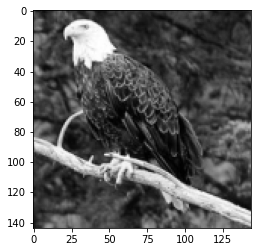

In [ ]:
plt.imshow(model_train_data[3], cmap='gray')

Get train data

In [ ]:
print(f"Train data shape {model_train_data.shape}\nTest  data shape {model_test_data.shape}")

Train data shape torch.Size([11684, 144, 144])
Test  data shape torch.Size([2063, 144, 144, 3])


Train

In [ ]:
best_autoencoder = None
best_score = 999

def add_noise(img):
	noise = torch.randn(img.size()) * 0.2
	noisy_img = img + noise.to(device)
	return noisy_img

def save_checkpoint(state, filename, is_best):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print("=> Saving new checkpoint")
        torch.save(state, filename)
    else:
        print("=> Validation Accuracy did not improve")
        
def pretrain(x_train, y_train, x_test, y_test, metric = None,  **kwargs):

    model = kwargs['model']
    num_epochs = kwargs['num_epochs']	
    start_epoch = 0 #checkpoint['epoch']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    # ======= train loader
    train_data = []
    for i in range(len(x_train)):
        train_data.append([x_train[i], y_train[i]])
    train_loader = DataLoader(dataset=train_data, batch_size=16)
    # =====

    errors = []
    for epoch in range(start_epoch, num_epochs):
        full = 0

        for data, lables in train_loader:
            
            dd = data.float().reshape([data.shape[0], dim, ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1]]).to(device)
            output = model(dd)    
            loss = nn.MSELoss()(output, dd) 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            full += loss.item()
    
        full = full / len(train_loader)
        
        errors.append(full)
        print("Epoch ",epoch,", error - ",full)
        
    return model, errors
        

In [ ]:
model = AutoEncoder().to(device)
!rm ./model.pth

'rm' is not recognized as an internal or external command,
operable program or batch file.


Model pretraining

In [ ]:
PATH = ""
if PATH not in os.listdir():
    model, errors = pretrain(model_train_data, model_train_labels, [], [], model=model, num_epochs=30)
else:
    model.load_state_dict(torch.load(PATH))
    model.eval()

Epoch  0 , error -  0.017561054322231567
Epoch  1 , error -  0.008706228228517784
Epoch  2 , error -  0.007315486391162864
Epoch  3 , error -  0.008446095621521635
Epoch  4 , error -  0.007611649739014548
Epoch  5 , error -  0.006920187890137228
Epoch  6 , error -  0.006583342603860084
Epoch  7 , error -  0.006437504652278592
Epoch  8 , error -  0.006530403616301787
Epoch  9 , error -  0.006258511774703127
Epoch  10 , error -  0.006062854990419178
Epoch  11 , error -  0.006010204507420209
Epoch  12 , error -  0.005925838494094958
Epoch  13 , error -  0.005822031369188191
Epoch  14 , error -  0.005850210658461875
Epoch  15 , error -  0.005741615573303563
Epoch  16 , error -  0.005774508405568539
Epoch  17 , error -  0.00575855484508773
Epoch  18 , error -  0.0056351679460070365
Epoch  19 , error -  0.005673346585860392
Epoch  20 , error -  0.005600194951262014
Epoch  21 , error -  0.005536165301816693
Epoch  22 , error -  0.005587855997022685
Epoch  23 , error -  0.005491062180520062
Ep

Plotting MSE loss

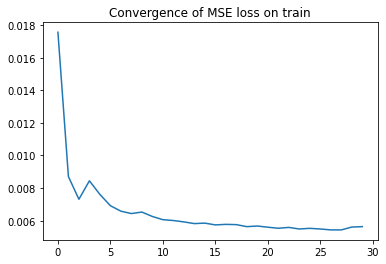

In [ ]:
plt.title('Convergence of MSE loss on train')
plt.plot(errors)

Saving trained model

In [ ]:
torch.save(model.state_dict(), "model.pth")

Get test data and show embedded image in RGB, R, G, and B mode 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


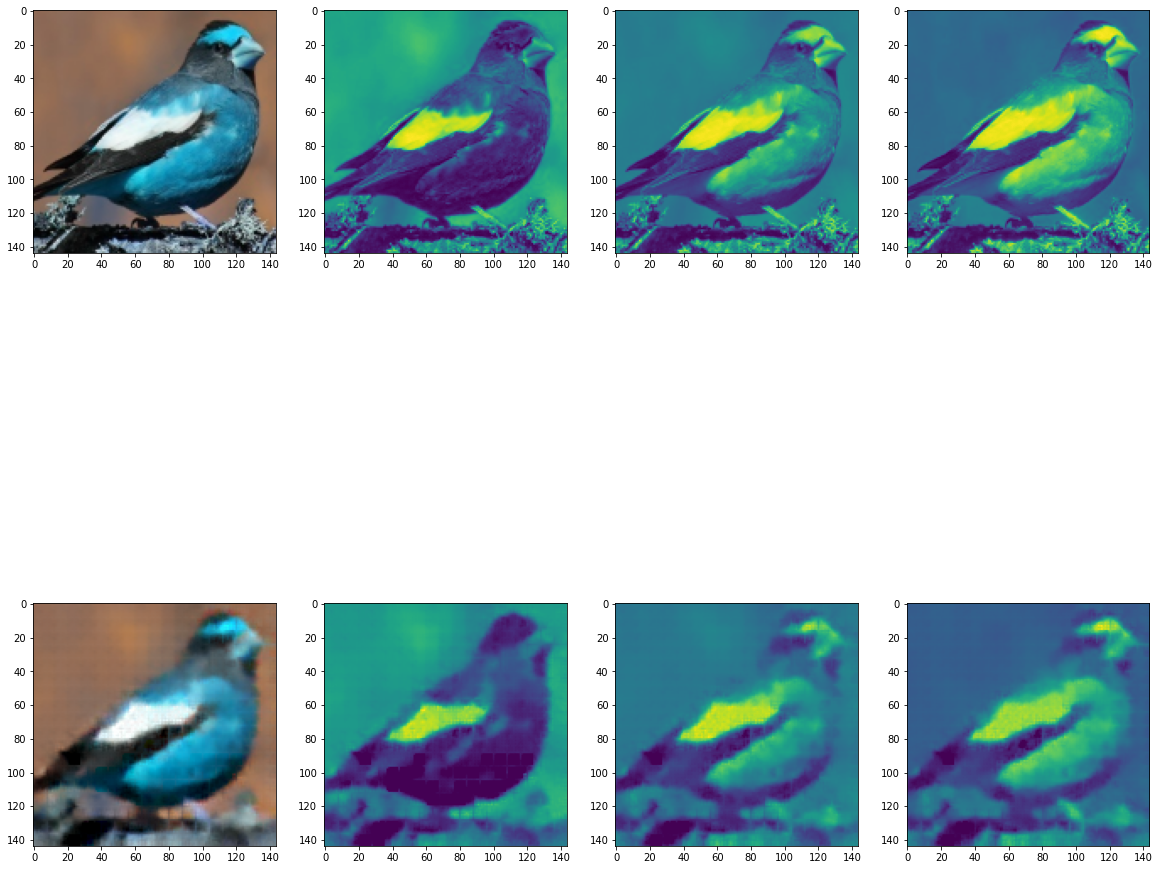

In [ ]:
def get_embedded_image(image):
    dd = image.to(device).float().reshape([dim, ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1]]).unsqueeze(0)
    output = model(dd)[0].reshape([ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1], dim]).detach().cpu().numpy()
    return output

def plot_test_and_embedded(model_test_data):
    plt.figure(figsize=(20, 20))
    j = 0
    for i in range(5):
        from random import choice
        rand = choice(model_test_data)
        plt.subplot(5, 2, j + 1)
        plt.imshow(rand)
        plt.subplot(5, 2, j + 2)
        plt.imshow(get_embedded_image(rand))
        j += 2
    plt.show()
    
def get_encoded(image):
    dd = image.to(device).float().reshape([dim, ENCODER_TRAIN_SHAPE[0], ENCODER_TRAIN_SHAPE[1]]).unsqueeze(0)
    output = model.encode(dd)[0].detach().cpu().numpy()
    return output
    
def concat_layers(corr):
    r = get_encoded(corr[:, :, 0])
    g = get_encoded(corr[:, :, 1])
    b = get_encoded(corr[:, :, 2])
    rgb = np.dstack((r,g,b))
    return rgb
    
def concat(corr):
    r = get_embedded_image(corr[:, :, 0])
    g = get_embedded_image(corr[:, :, 1])
    b = get_embedded_image(corr[:, :, 2])
    rgb = np.dstack((r,g,b))
    return r, g, b, rgb
    
def plot_encoded_results(rand, h, w):  
    gray = torch.from_numpy(cv2.cvtColor(rand, cv2.COLOR_BGR2GRAY))
    corr = torch.from_numpy(rand)
    r, g, b, rgb = concat(corr)
    plt.imshow(rgb)
    plt.subplot(h, w, 6)
    plt.imshow(r)
    plt.subplot(h, w, 7)
    plt.imshow(g)
    plt.subplot(h, w, 8)
    plt.imshow(b)
    plt.show()
    
def plot_rgb_from_gray():
    from random import choice
    h, w = 2, 4
    rand = choice(model_test_data).float().numpy()
    plt.figure(figsize=(20, 20))
    plt.subplot(h, w, 1)
    plt.imshow(rand, cmap='gray')
    plt.subplot(h, w, 2)
    plt.imshow(rand[:,:,0])
    plt.subplot(h, w, 3)
    plt.imshow(rand[:,:,1])
    plt.subplot(h, w, 4)
    plt.imshow(rand[:,:,2])
    plt.subplot(h, w, 5)
    plot_encoded_results(rand, h, w)
    
def plot_by_pair():
    from random import choice
    h, w = 5, 2
    
    plt.figure(figsize=(20, 20))
    
    for i in range(1, h*w+1, 2):
        rand = choice(model_test_data)
        plt.subplot(h, w, i)
        plt.imshow(rand)

        plt.subplot(h, w, i+1)
        plt.imshow(concat(rand)[3])

    
plot_rgb_from_gray()

Show original and embedded image in pairs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


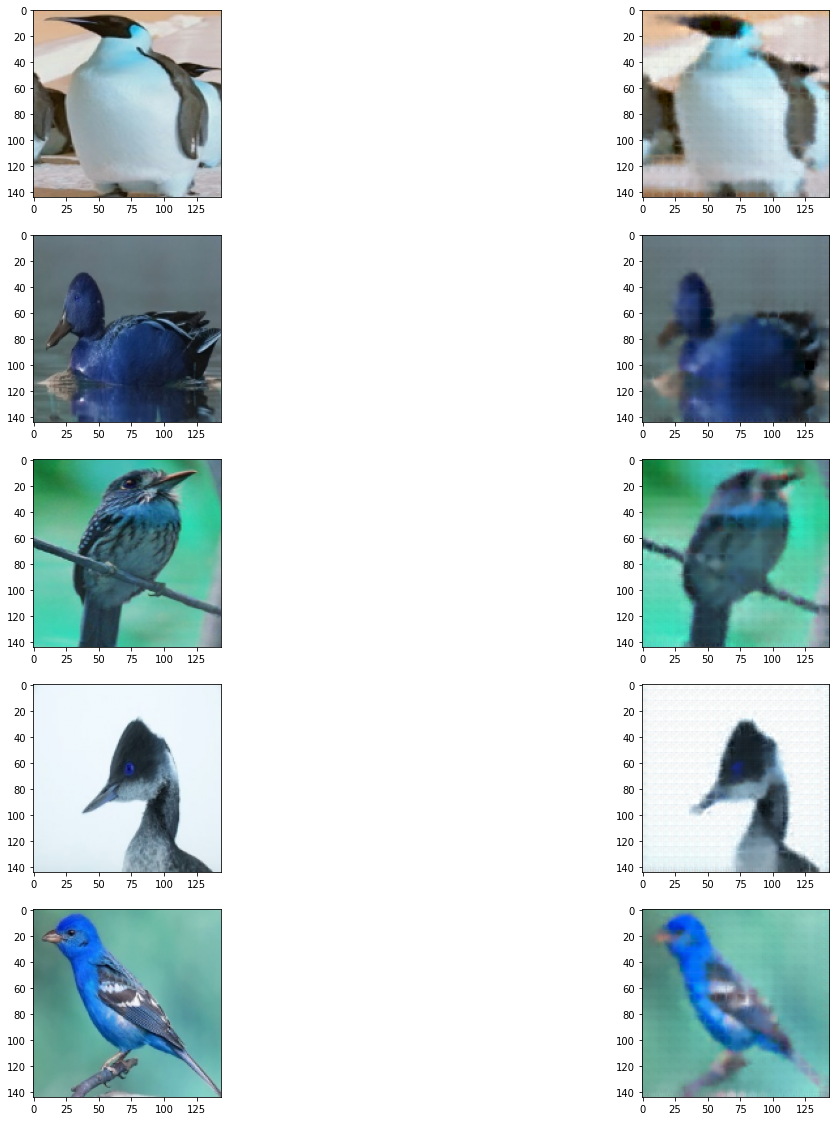

In [ ]:
plot_by_pair()

Get embedded data

In [ ]:
def get_embeded_data(model_test_data):
    loader = DataLoader(dataset=model_test_data)
    embedded = []
    for im in tqdm(loader):
        rgb = concat_layers(im[0])
        embedded.append(rgb.flatten())
    return np.array(embedded)

torch.cuda.empty_cache()

embedded_train = get_embeded_data(model_train_knn)
embedded_test = get_embeded_data(model_test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2063/2063 [00:08<00:00, 257.77it/s]


Fit KNN classifier

In [ ]:
each = 1
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(embedded_train[::each], model_train_labels[::each])

KNeighborsClassifier()

Show accuracy

In [ ]:
each_test = 1
pred_knn_autoencoder = clf.predict(embedded_test[::each_test])
accuracy_score(model_test_labels[::each_test], pred_knn_autoencoder)

0.286960736791081

As we see our autoencoder for some classes found higher level features which describe objects good

<AxesSubplot:>

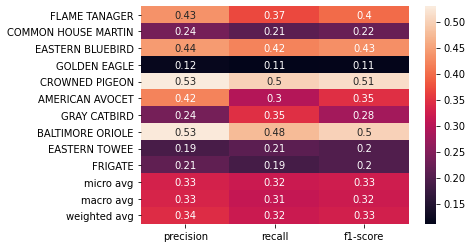

In [ ]:
res = classification_report(model_test_labels, pred_knn_autoencoder, labels=list(range(10)), target_names=encoder, output_dict=True)
sns.heatmap(pd.DataFrame(res).iloc[:-1, :].T, annot=True)

In [ ]:
res = classification_report(model_test_labels, pred_knn_autoencoder, labels=list(range(10)), target_names=encoder)
print(res)

                        precision    recall  f1-score   support

         FLAME TANAGER       0.43      0.37      0.40        27
   COMMON HOUSE MARTIN       0.24      0.21      0.22        19
      EASTERN BLUEBIRD       0.44      0.42      0.43        19
          GOLDEN EAGLE       0.12      0.11      0.11        18
        CROWNED PIGEON       0.53      0.50      0.51        18
       AMERICAN AVOCET       0.42      0.30      0.35        27
          GRAY CATBIRD       0.24      0.35      0.28        23
      BALTIMORE ORIOLE       0.53      0.48      0.50        21
         EASTERN TOWEE       0.19      0.21      0.20        19
               FRIGATE       0.21      0.19      0.20        16

             micro avg       0.33      0.32      0.33       207
             macro avg       0.33      0.31      0.32       207
          weighted avg       0.34      0.32      0.33       207



Show only resized image

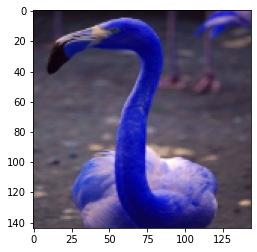

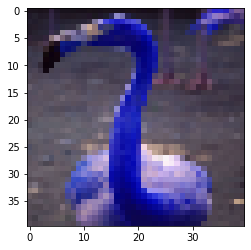

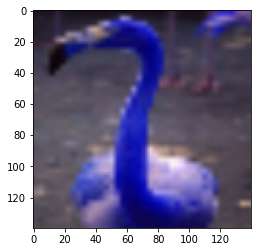

In [ ]:
im = cv2.resize(model_train_knn[0].numpy(), (40,40))
plt.imshow(model_train_knn[0].numpy())
plt.figure()
plt.imshow(im)
plt.figure()
plt.imshow(cv2.resize(im, (140,140)))

Train KNN on resized images

In [ ]:
def resize_model(data):
    return np.array([cv2.resize(im.numpy(), (50,50)).flatten() for im in data])

train_knn_resized = resize_model(model_train_knn)
test_knn_resized = resize_model(model_test_data)

In [ ]:
clf_2 = KNeighborsClassifier(n_neighbors=5)
clf_2.fit(train_knn_resized, model_train_labels)
pred = clf_2.predict(test_knn_resized)
accuracy_score(model_test_labels, pred)

0.12263693650024236

Show classification report

In [ ]:
res = classification_report(model_test_labels, pred,  target_names=encoder)
print(res)

                        precision    recall  f1-score   support

         FLAME TANAGER       0.16      0.37      0.22        27
   COMMON HOUSE MARTIN       0.09      0.32      0.14        19
      EASTERN BLUEBIRD       0.04      0.32      0.07        19
          GOLDEN EAGLE       0.04      0.11      0.06        18
        CROWNED PIGEON       0.21      0.33      0.26        18
       AMERICAN AVOCET       0.00      0.00      0.00        27
          GRAY CATBIRD       0.05      0.39      0.10        23
      BALTIMORE ORIOLE       0.15      0.38      0.22        21
         EASTERN TOWEE       0.14      0.11      0.12        19
               FRIGATE       0.11      0.19      0.14        16
           BLUE GROUSE       0.01      0.04      0.02        28
       COUCHS KINGBIRD       0.04      0.10      0.06        21
    AMERICAN GOLDFINCH       0.21      0.20      0.21        20
BLACK-CAPPED CHICKADEE       0.20      0.10      0.13        20
       BLACK FRANCOLIN       0.00      

c:\users\rinat\projects\birdclassification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shw precision, recall and f1 score for first 10 classes

c:\users\rinat\projects\birdclassification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1945: UserWarning: labels size, 10, does not match size of target_names, 100
  warnings.warn(


<AxesSubplot:>

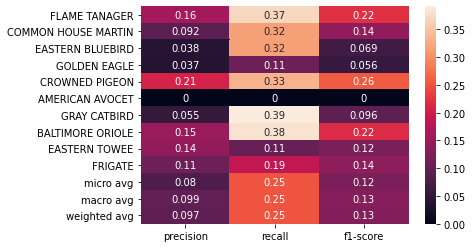

In [ ]:
res = classification_report(model_test_labels, pred, labels=list(range(10)), target_names=encoder, output_dict=True)
sns.heatmap(pd.DataFrame(res).iloc[:-1, :].T, annot=True)